In [1]:
# ==========================================================
# Carga y exploración inicial del archivo supplemental_metadata.csv
# ==========================================================
import pandas as pd

# Ruta al archivo (ajusta según tu carpeta)
CSV_PATH = "supplemental_metadata.csv"

# 1. Cargar datos
meta = pd.read_csv(CSV_PATH)
print("Dimensiones del dataset:", meta.shape)
print("\nColumnas disponibles:\n", meta.columns.tolist())

# 2. Vista rápida de las primeras filas
print("\nPrimeras filas del dataset:")
print(meta.head())

# 3. Tipos de datos
print("\nTipos de datos por columna:")
print(meta.dtypes)

# 4. Valores nulos
print("\nConteo de valores nulos por columna:")
print(meta.isna().sum())

# ==========================================================
# Análisis de variables categóricas clave
# ==========================================================
# Número de participantes únicos
n_participants = meta["participant_id"].nunique()
print("\nNúmero de participantes únicos:", n_participants)

# Número de secuencias
n_sequences = meta["sequence_id"].nunique()
print("Número de secuencias únicas:", n_sequences)

# Número de frases distintas
n_phrases = meta["phrase"].nunique()
print("Número de frases distintas:", n_phrases)

# ==========================================================
# Distribución de frases (top 10)
# ==========================================================
print("\nTop 10 frases más frecuentes:")
print(meta["phrase"].value_counts().head(10))

# ==========================================================
# Variable derivada: primera letra de cada frase
# ==========================================================
meta["letter"] = meta["phrase"].astype(str).str.strip().str.lower().str[0]

# Distribución por letra
print("\nDistribución por letra:")
print(meta["letter"].value_counts().sort_index())


Dimensiones del dataset: (52958, 5)

Columnas disponibles:
 ['path', 'file_id', 'sequence_id', 'participant_id', 'phrase']

Primeras filas del dataset:
                                      path   file_id  sequence_id  \
0  supplemental_landmarks/33432165.parquet  33432165   1535467051   
1  supplemental_landmarks/33432165.parquet  33432165   1535499058   
2  supplemental_landmarks/33432165.parquet  33432165   1535530550   
3  supplemental_landmarks/33432165.parquet  33432165   1535545499   
4  supplemental_landmarks/33432165.parquet  33432165   1535585216   

   participant_id                                    phrase  
0             251         coming up with killer sound bites  
1             239                we better investigate this  
2             245          interesting observation was made  
3              38              victims deserve more redress  
4             254  knee bone is connected to the thigh bone  

Tipos de datos por columna:
path              object
file_id

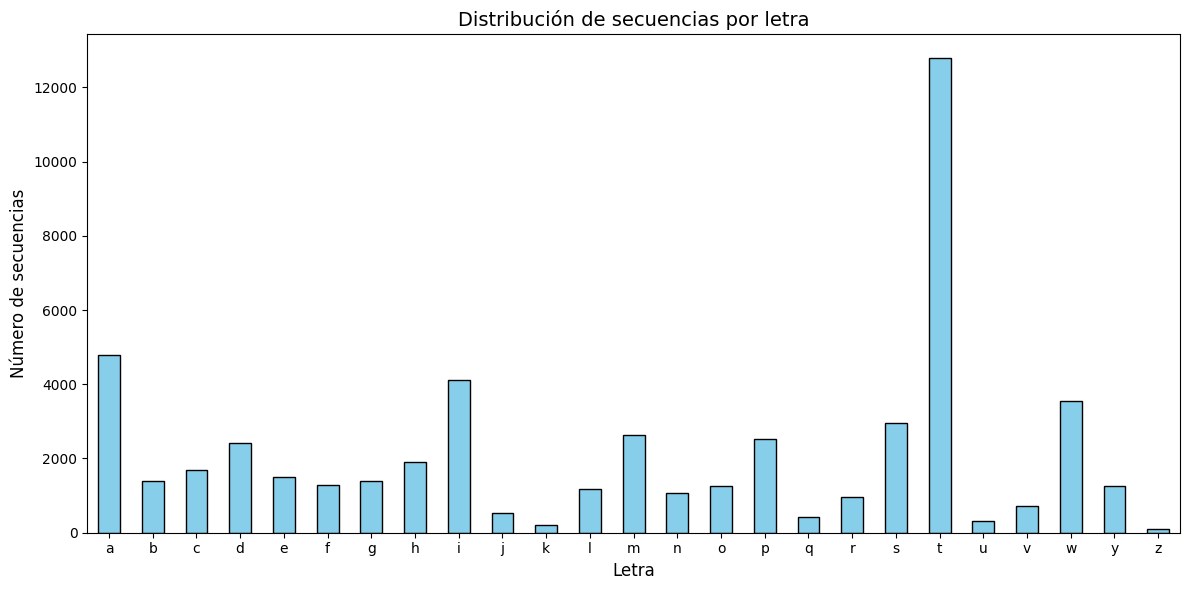

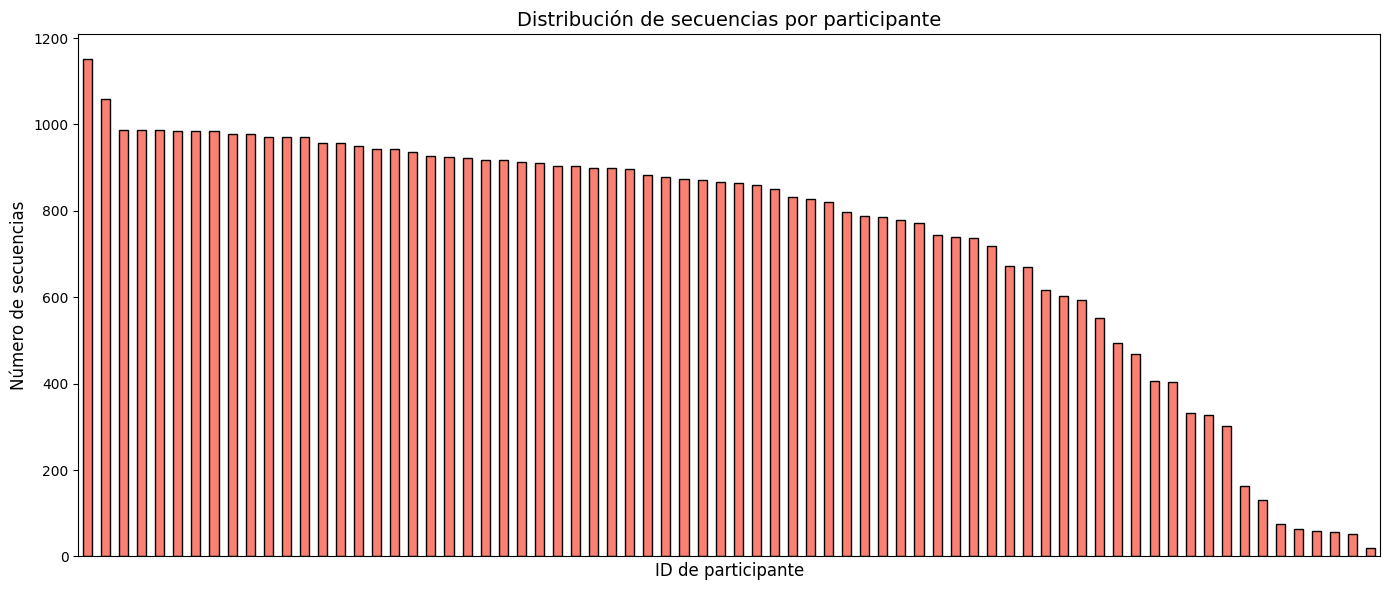

In [2]:
import matplotlib.pyplot as plt

# ================================
# Gráfico 1: Distribución de letras
# ================================
plt.figure(figsize=(12,6))
meta["letter"].value_counts().sort_index().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribución de secuencias por letra", fontsize=14)
plt.xlabel("Letra", fontsize=12)
plt.ylabel("Número de secuencias", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# =========================================
# Gráfico 2: Distribución por participante
# =========================================
plt.figure(figsize=(14,6))
meta["participant_id"].value_counts().plot(kind="bar", color="salmon", edgecolor="black")
plt.title("Distribución de secuencias por participante", fontsize=14)
plt.xlabel("ID de participante", fontsize=12)
plt.ylabel("Número de secuencias", fontsize=12)
plt.xticks([], [])
plt.tight_layout()
plt.show()


In [3]:
# ==========================================================
# Limpieza y preprocesamiento de supplemental_metadata.csv
# ==========================================================
import pandas as pd
import numpy as np
from pathlib import Path
import string

# ---------- 0) Config ----------
CSV_PATH = "supplemental_metadata.csv"
OUT_DIR  = Path("eda_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- 1) Carga ----------
meta = pd.read_csv(CSV_PATH)
print("Dimensiones iniciales:", meta.shape)
print("Columnas:", meta.columns.tolist())

# ---------- 2) Normalización de texto ----------
# strip + lower para evitar duplicados y variaciones de formato
meta["phrase"] = (
    meta["phrase"]
    .astype(str)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
    .str.lower()
)

# ---------- 3) Derivación de variable categórica: letter ----------
# Toma la primera letra alfabética de la frase;
# si no hay letras a-z al inicio, la marca como 'otra'
def first_letter_alpha(s: str) -> str:
    s = s.strip().lower()
    for ch in s:
        if ch in string.ascii_lowercase:
            return ch
    return "otra"

meta["letter"] = meta["phrase"].apply(first_letter_alpha)

# ---------- 4) Validación de claves y duplicados ----------
dup_seq  = meta.duplicated(subset=["sequence_id"], keep=False)
dup_file = meta.duplicated(subset=["file_id"],     keep=False)

n_dup_seq  = dup_seq.sum()
n_dup_file = dup_file.sum()

print(f"\nDuplicados por sequence_id: {n_dup_seq}")
print(f"Duplicados por file_id:     {n_dup_file}")

# Guarda ejemplos de duplicados (si existen)
if n_dup_seq > 0:
    meta[dup_seq].sort_values(["sequence_id"]).head(20).to_csv(OUT_DIR/"ejemplos_duplicados_sequence.csv", index=False)
if n_dup_file > 0:
    meta[dup_file].sort_values(["file_id"]).head(20).to_csv(OUT_DIR/"ejemplos_duplicados_file.csv", index=False)

# Opcional: eliminar duplicados conservando el primero
meta_nodup = meta.drop_duplicates(subset=["sequence_id"]).copy()
print("Dimensiones tras drop_duplicates(sequence_id):", meta_nodup.shape)

# ---------- 5) Valores faltantes ----------
nulls = meta_nodup.isna().sum().sort_values(ascending=False)
print("\nValores nulos por columna:\n", nulls)

# ---------- 6) Frecuencia absoluta y relativa por letra ----------
freq_letter_abs = meta_nodup["letter"].value_counts(dropna=False).sort_index()
freq_letter_rel = (freq_letter_abs / freq_letter_abs.sum()).round(4)

freq_letters = pd.DataFrame({
    "count": freq_letter_abs,
    "ratio": freq_letter_rel
})
print("\nDistribución por letra (primeras filas):\n", freq_letters.head(10))

# Guarda tablas
freq_letters.to_csv(OUT_DIR/"freq_letters.csv")
meta_nodup["participant_id"].value_counts().to_csv(OUT_DIR/"freq_participants.csv")

# ---------- 7) Métricas simples de desbalance ----------
# (a) top/bottom letras
top_letters = freq_letters.sort_values("count", ascending=False).head(5)
bot_letters = freq_letters[freq_letters.index != "otra"].sort_values("count", ascending=True).head(5)

print("\nTop 5 letras más frecuentes:\n", top_letters)
print("\nBottom 5 letras menos frecuentes (sin 'otra'):\n", bot_letters)

# (b) índice de Gini sobre distribución de letras (sin 'otra')
dist = freq_letters.loc[[l for l in freq_letters.index if l != "otra"], "ratio"].to_numpy()
dist = dist[dist > 0]
if dist.size:
    # Gini clásico
    dist_sorted = np.sort(dist)
    n = dist_sorted.size
    gini = (np.sum((2*np.arange(1, n+1)-n-1) * dist_sorted) / (n * np.sum(dist_sorted)))
    gini = float(np.abs(gini))
    print(f"\nÍndice de Gini (letras): {gini:.4f}  -> 0=perfectamente balanceado, 1=desbalance extremo")
else:
    print("\nNo fue posible calcular Gini (distribución vacía).")

# ---------- 8) Distribución por participante ----------
freq_part = meta_nodup["participant_id"].value_counts()
print("\nParticipantes únicos:", meta_nodup["participant_id"].nunique())
print("Estadísticos #secuencias por participante:")
print(freq_part.describe())

# ---------- 9) Guardado del dataset limpio ----------
OUT_CSV = OUT_DIR/"metadata_clean.csv"
meta_nodup.to_csv(OUT_CSV, index=False)
print(f"\nDataset limpio guardado en: {OUT_CSV.resolve()}")

# ---------- 10) Pequeño reporte resumen ----------
summary = {
    "rows_iniciales": int(len(meta)),
    "rows_limpios": int(len(meta_nodup)),
    "cols": int(meta_nodup.shape[1]),
    "n_participantes": int(meta_nodup['participant_id'].nunique()),
    "n_secuencias": int(meta_nodup['sequence_id'].nunique()),
    "n_frases": int(meta_nodup['phrase'].nunique()),
    "n_duplicados_sequence": int(n_dup_seq),
    "n_duplicados_file": int(n_dup_file),
    "gini_letras": float(gini) if dist.size else None
}
pd.Series(summary).to_csv(OUT_DIR/"resumen_limpieza.csv")
print("\nResumen limpieza/preprocesamiento:")
print(pd.Series(summary))


Dimensiones iniciales: (52958, 5)
Columnas: ['path', 'file_id', 'sequence_id', 'participant_id', 'phrase']

Duplicados por sequence_id: 0
Duplicados por file_id:     52958
Dimensiones tras drop_duplicates(sequence_id): (52958, 6)

Valores nulos por columna:
 path              0
file_id           0
sequence_id       0
participant_id    0
phrase            0
letter            0
dtype: int64

Distribución por letra (primeras filas):
         count   ratio
letter               
a        4788  0.0904
b        1384  0.0261
c        1680  0.0317
d        2410  0.0455
e        1500  0.0283
f        1280  0.0242
g        1400  0.0264
h        1904  0.0360
i        4126  0.0779
j         524  0.0099

Top 5 letras más frecuentes:
         count   ratio
letter               
t       12790  0.2415
a        4788  0.0904
i        4126  0.0779
w        3543  0.0669
s        2952  0.0557

Bottom 5 letras menos frecuentes (sin 'otra'):
         count   ratio
letter               
z         104  0.0020
k

# Análisis Descriptivo adicional

Viendo los descubrimientos de variables anteriormente, tratamos de profundizar en el lado estadistico, viendo valores faltantes, correlaciones y posibles outliers


,path,file_id,sequence_id,participant_id,phrase,letter
count,52958,5.295800e+04,5.295800e+04,52958.000000,52958,52958
unique,53,NaN,NaN,NaN,508,25
top,supplemental_landmarks/33432165.parquet,NaN,NaN,NaN,why do you ask silly questions,t
freq,1000,NaN,NaN,NaN,117,12790
mean,NaN,9.680392e+08,1.072800e+09,132.738661,NaN,NaN
std,NaN,5.779288e+08,6.165748e+08,81.745528,NaN,NaN
min,NaN,3.343216e+07,2.869900e+04,0.000000,NaN,NaN
25%,NaN,4.717666e+08,5.411308e+08,53.000000,NaN,NaN
50%,NaN,8.972877e+08,1.069840e+09,135.000000,NaN,NaN
75%,NaN,1.471342e+09,1.606032e+09,216.000000,NaN,NaN


Valores faltantes por columna:
path              0
file_id           0
sequence_id       0
participant_id    0
phrase            0
letter            0
dtype: int64


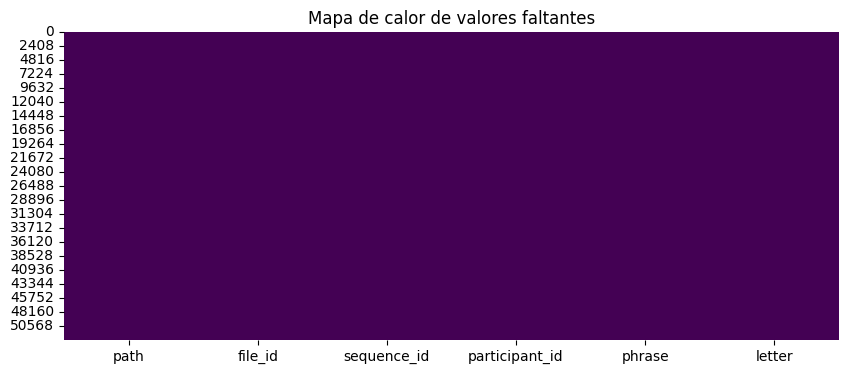

Matriz de correlación:
                 file_id  sequence_id  participant_id
file_id         1.000000    -0.061255       -0.001481
sequence_id    -0.061255     1.000000        0.003102
participant_id -0.001481     0.003102        1.000000


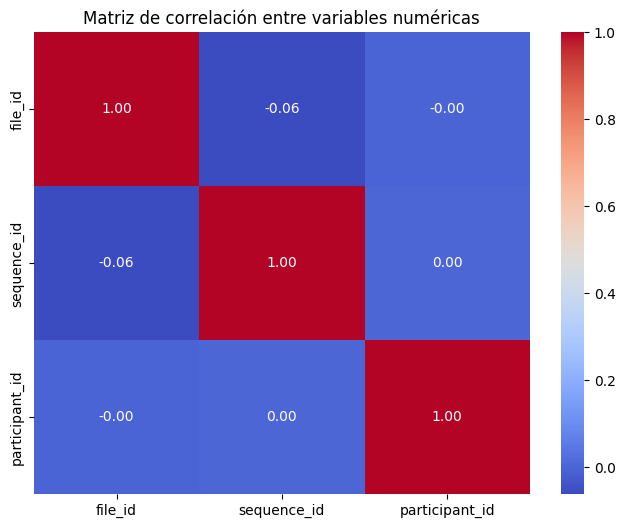

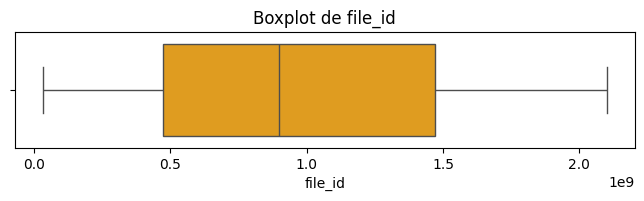

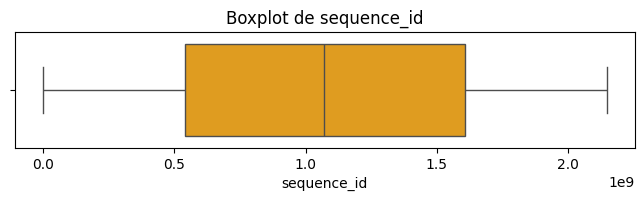

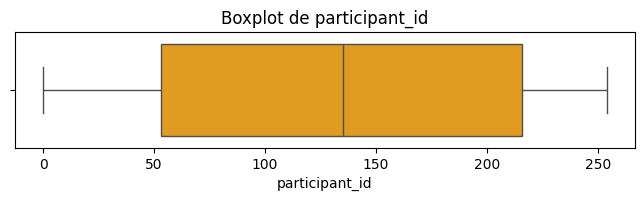

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

meta = pd.read_csv('eda_outputs/metadata_clean.csv') if pd.io.common.file_exists('eda_outputs/metadata_clean.csv') else pd.read_csv('supplemental_metadata.csv')

# Estadísticas descriptivas generales
desc = meta.describe(include='all')
display(desc)

# Valores faltantes por columna
missing = meta.isnull().sum()
print('Valores faltantes por columna:')
print(missing)

# Visualización de valores faltantes
plt.figure(figsize=(10,4))
sns.heatmap(meta.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de calor de valores faltantes')
plt.show()

# Análisis de correlaciones
if meta.select_dtypes(include='number').shape[1] > 1:
    corr = meta.select_dtypes(include='number').corr()
    print('Matriz de correlación:')
    print(corr)
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Matriz de correlación entre variables numéricas')
    plt.show()
else:
    print('No hay suficientes variables numéricas para análisis de correlación.')

# Detección de outliers en variables numéricas
num_cols = meta.select_dtypes(include='number').columns
for col in num_cols:
    plt.figure(figsize=(8,1.5))
    sns.boxplot(x=meta[col], color='orange')
    plt.title(f'Boxplot de {col}')
    plt.show()

## Análisis

Viendo las grafica, estas no muestran una gran relacion entre las variables numericas que definimos como "principales" en este dataset. Esto se puede esperar por que estos son identificadores. Viendo los boxplot, podemos entender como es que se distribuyen los valores de estas variables y en este caso, podemos ver que son bastante uniformes, o sea que no se logran observar outliers extremos. 

En general, estos datos parecen estar bastante bien distribuidos y no tienen problemas graves en cuanto a valores atípicos o correlaciones inesperadas se refiere.

# Gráficas adicionales para el contexto de ASL

C:\Users\sebas\AppData\Local\Temp\ipykernel_11112\2285350847.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=letras.index, y=letras.values, palette='viridis')


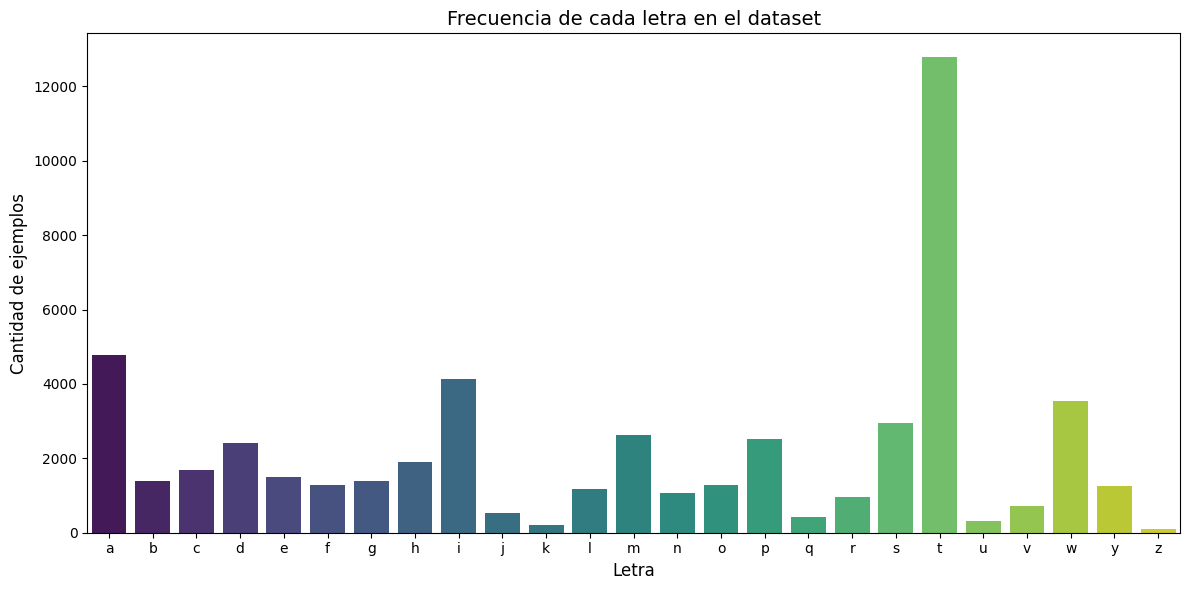

C:\Users\sebas\AppData\Local\Temp\ipykernel_11112\2285350847.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=participantes.index.astype(str), y=participantes.values, palette='magma')


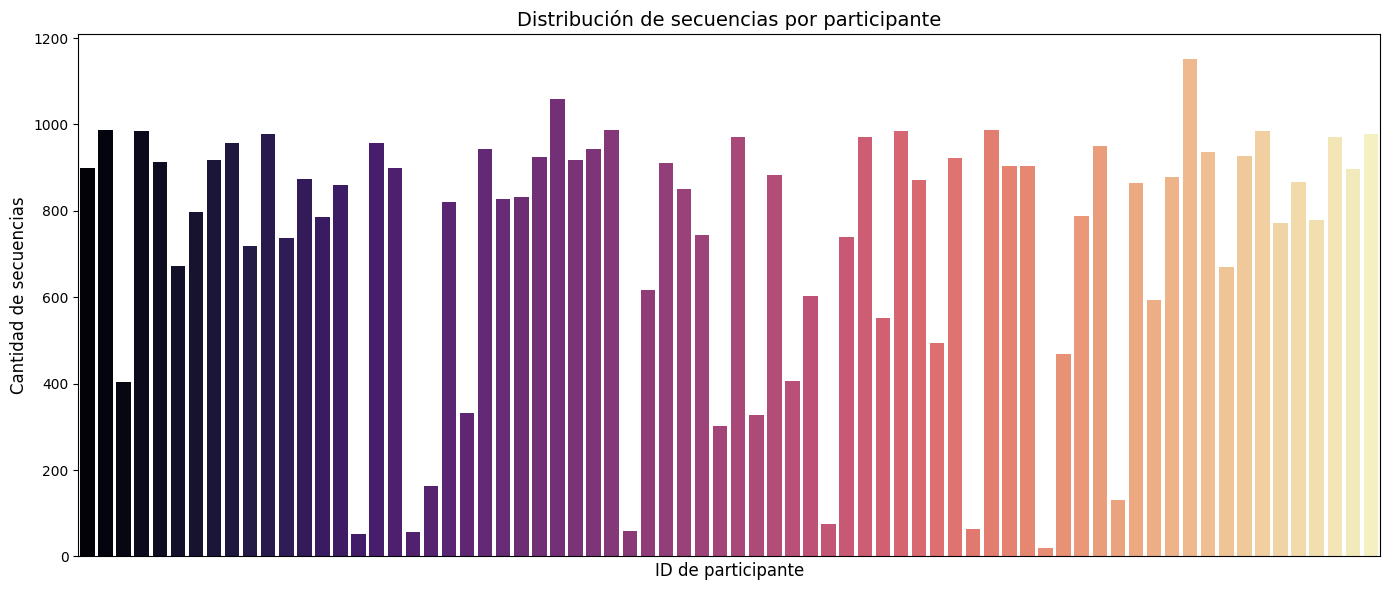

In [ ]:
# Gráfica: Frecuencia de cada letra en el dataset
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

meta = pd.read_csv('eda_outputs/metadata_clean.csv') if pd.io.common.file_exists('eda_outputs/metadata_clean.csv') else pd.read_csv('supplemental_metadata.csv')

plt.figure(figsize=(12,6))
letras = meta['letter'].value_counts().sort_index()
sns.barplot(x=letras.index, y=letras.values, palette='viridis')
plt.title('Frecuencia de cada letra en el dataset', fontsize=14)
plt.xlabel('Letra', fontsize=12)
plt.ylabel('Cantidad de ejemplos', fontsize=12)
plt.tight_layout()
plt.show()

# Gráfica: Distribución de secuencias por participante
plt.figure(figsize=(14,6))
participantes = meta['participant_id'].value_counts().sort_index()
sns.barplot(x=participantes.index.astype(str), y=participantes.values, palette='magma')
plt.title('Distribución de secuencias por participante', fontsize=14)
plt.xlabel('ID de participante', fontsize=12)
plt.ylabel('Cantidad de secuencias', fontsize=12)
plt.xticks([], [])
plt.tight_layout()
plt.show()

### Interpretación:

La primera gráfica muestra claramente el desbalance en la frecuencia de las letras, lo que es fundamental para el reconocimiento automático: algunas letras aparecen mucho más que otras, lo que puede afectar el desempeño de los modelos si no se corrige. La segunda gráfica evidencia que la contribución de los participantes no es homogénea. algunos aportan muchas más secuencias que otros, lo que puede introducir sesgos y debe considerarse en el análisis y modelado.